<a href="https://colab.research.google.com/github/vasilyryabtsev/futures-price-prediction/blob/dev/ds/twitter/notebooks/ml_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
# import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
# from transformers import BertTokenizer, BertForSequenceClassification, pipeline, AutoTokenizer, AutoModelForSequenceClassification
# from gensim.models import Word2Vec
import optuna
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
import sys
import os
import warnings
warnings.filterwarnings('ignore')


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from pipelines.tokenizers import tweet_tokenizer
import pickle

RANDOM_STATE = 42

# df = pd.read_csv('https://github.com/vasilyryabtsev/futures-price-prediction/blob/dev/ds/twitter/data/processed.csv?raw=true')
df = pd.read_csv('../data/processed.csv')

Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop('1_day_after', axis=1), df['1_day_after'], test_size=0.2, random_state=RANDOM_STATE)

curves = {}

def add_curve(model, name):
    """
    Построение ROC кривой.
    """
    fpr, tpr, thresholds = roc_curve(ytest, model.predict_proba(Xtest)[:, 1])
    roc_auc = auc(fpr, tpr)

    curves[name] = {'fpr': fpr,
                    'tpr': tpr,
                    'thresholds': thresholds,
                    'roc_auc': roc_auc}

def print_metrics(model):
    print(f'ROC-AUC train: {roc_auc_score(ytrain, model.predict_proba(Xtrain)[:, 1])}')
    print(f'ROC-AUC test: {roc_auc_score(ytest, model.predict_proba(Xtest)[:, 1])}')
    print('Classification report for test:')
    print(classification_report(ytest, model.predict(Xtest)))

## Текстовые признаки

### Bag Of Words

In [2]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(tokenizer=tweet_tokenizer), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing",ct),
    ("classifier", LogisticRegression(max_iter=10000, random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 8782
ROC-AUC train: 0.9530478632691644
ROC-AUC test: 0.5516647727272728
Classification report for test:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50       800
           1       0.55      0.57      0.56       880

    accuracy                           0.53      1680
   macro avg       0.53      0.53      0.53      1680
weighted avg       0.53      0.53      0.53      1680



In [3]:
for w in pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out():
    print(w)

#13fpredict
#1776challeng
#3m
#3thingstowatch
#aapl
#aca
#accentur
#ad
#adob
#ai
#allergan
#alphabet
#amazon
#amazonprim
#amazonprimeday
#americassandbox
#amzn
#andtypo
#aol
#appl
#appmesh
#ark
#askforb
#askhowardlindzon
#bank
#bankofamerica
#beat
#beforemanzielgetsdraft
#berkshirehathaway
#bing
#biontech
#biotech
#bitcoin
#blackrock
#boe
#bond
#breakupthebeast
#brexit
#btc
#butposs
#buyout
#buzzwordbingo
#cabl
#cantstopwontstop
#chinesemicrocaporuslargecap
#cisco
#cleanenergi
#clorox
#cloud
#cloudcomput
#cnbccrypto
#cocacola
#coke
#comcast
#confessyourunpopularopinion
#consum
#coronaviru
#corpgov
#corporategovern
#covid19
#crm
#cx
#deliveringalpha
#dinotech
#disappoint
#disney
#dividend
#dividendstock
#dol'
#dominionenergi
#dotcom
#earn
#easycomeeasygo
#easygam
#echo
#economicmoat
#ehhh
#elonmusk
#energi
#equityraisetheroof
#esg
#espn
#etf
#ev
#facebook
#fangtrad
#fcpa
#fedex
#ff
#fia14
#fidel
#firstdayoffal
#firstft
#foia
#forbescio
#gamestop
#generalmil
#gigafactori
#gilead
#googl
#

In [4]:
def objective(trial):
    # CountVectorizer
    max_features = trial.suggest_int("max_features", 500, 8501, step=1000)
    ngram_range = trial.suggest_categorical("ngram_range", [(1,1), (1,2), (1,3)])
    min_df = trial.suggest_float("min_df", 1e-5, 0.05, log=True)
    max_df = trial.suggest_float("max_df", 0.5, 1.0)

    # LogisticRegression
    C = trial.suggest_loguniform("C", 1e-4, 1e2)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    
    ct = ColumnTransformer([
        ("vectorizer", CountVectorizer(
            tokenizer=tweet_tokenizer,
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=min_df,
            max_df=max_df
        ), 'text')
    ], remainder='drop')

    pl = Pipeline([
        ("prepocessing", ct),
        ("classifier", LogisticRegression(C=C, penalty=penalty, solver="liblinear", max_iter=10000, random_state=42))
    ])

    score = cross_val_score(pl, Xtrain, ytrain, cv=5, scoring="roc_auc").mean()

    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:", study.best_trial.params)


[I 2025-03-13 19:52:37,564] A new study created in memory with name: no-name-741537c9-188b-4cca-900a-c019dfb8ce7e
[I 2025-03-13 19:53:04,491] Trial 0 finished with value: 0.5270694434732971 and parameters: {'max_features': 4500, 'ngram_range': (1, 3), 'min_df': 0.008397827194058951, 'max_df': 0.8684604240037992, 'C': 11.614829018025508, 'penalty': 'l1'}. Best is trial 0 with value: 0.5270694434732971.
[I 2025-03-13 19:53:23,795] Trial 1 finished with value: 0.5160306604401541 and parameters: {'max_features': 1500, 'ngram_range': (1, 1), 'min_df': 0.004490251831317845, 'max_df': 0.8537312517274384, 'C': 0.0007529627059929218, 'penalty': 'l2'}. Best is trial 0 with value: 0.5270694434732971.
[I 2025-03-13 19:53:45,828] Trial 2 finished with value: 0.5377445462234454 and parameters: {'max_features': 1500, 'ngram_range': (1, 1), 'min_df': 0.0034360856308227506, 'max_df': 0.5698020593060206, 'C': 1.1967587474929946, 'penalty': 'l2'}. Best is trial 2 with value: 0.5377445462234454.
[I 2025-0

Best trial: {'max_features': 7500, 'ngram_range': (1, 3), 'min_df': 0.00047869995907108526, 'max_df': 0.6698757755882585, 'C': 1.3033723265818171, 'penalty': 'l2'}


In [56]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(
        tokenizer=tweet_tokenizer,
        max_features=7500,
        ngram_range=(1, 3),
        min_df=0.00047869995907108526,
        max_df=0.6698757755882585
    ), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing", ct),
    ("classifier", LogisticRegression(C=1.3033723265818171, penalty='l2', solver="liblinear", max_iter=10000, random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 6868
ROC-AUC train: 0.9537013614694186
ROC-AUC test: 0.5490674715909092
Classification report for test:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       800
           1       0.56      0.57      0.57       880

    accuracy                           0.54      1680
   macro avg       0.54      0.54      0.54      1680
weighted avg       0.54      0.54      0.54      1680



In [6]:
for w in pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out():
    print(w)

#alphabet
#alphabet #appl
#alphabet #appl #facebook
#amazon
#appl
#appl #facebook
#appl #facebook #microsoft
#bank
#bank nflxtckr
#bank nflxtckr jnjtckr
#bitcoin
#btc
#cnbccrypto
#cnbccrypto linktkn
#cnbccrypto linktkn linktkn
#corpgov
#dinotech
#disney
#dividend
#earn
#esg
#facebook
#facebook #microsoft
#facebook #microsoft #netflix
#foia
#googl
#investor
#investor here'
#johnsonandjohnson
#johnsonandjohnson peptckr
#johnsonandjohnson peptckr jnjtckr
#jpmorgan
#merck
#microsoft
#microsoft #netflix
#microsoft #netflix valu
#netflix
#netflix valu
#netflix valu googtckr
#numtkn
#pepsi
#pepsi #johnsonandjohnson
#pepsi #johnsonandjohnson peptckr
#pfizer
#selfmadewomen
#selfmadewomen linktkn
#starbuck
#stock
#stockpick
#stockpick week
#stockpick week linktkn
#tech
#tesla
#tesla tslatckr
#weekahead
):
): aapltckr
): aapltckr call
): aapltckr prem
): aapltckr put
): babatckr
): linktkn
): linktkn linktkn
): metatckr
): nflxtckr
): nvdatckr
): nvdatckr call
): nvdatckr put
): spytckr
): spytck

In [12]:
feature_names = pl.named_steps["prepocessing"].named_transformers_["vectorizer"].get_feature_names_out()

coef = pl.named_steps["classifier"].coef_.flatten()

top_features = np.argsort(abs(coef))[-25:]

for i in reversed(top_features):
    print(f"{feature_names[i]}: {coef[i]:.2f}")

gldtckr: -1.79
distckr linktkn: 1.74
linktkn msfttckr: -1.74
hd: -1.65
lowest: -1.63
sport: 1.63
im: 1.61
malon: -1.60
lie: 1.60
last time: 1.57
xbox: -1.54
instal: -1.53
transit: 1.51
cmcsatckr linktkn: 1.49
appl amd: -1.49
ft: 1.48
era: -1.48
connect: 1.48
gp: 1.48
placement: -1.47
numtkn.numtkn linktkn: -1.46
dump: -1.43
scale: -1.42
appl aapltckr numtkn: 1.42
valueact: 1.42


In [57]:
add_curve(pl, 'bow-logreg')

In [14]:
with open('../models/bow-logreg.pickle', 'wb') as file:
    pickle.dump(pl, file)

In [39]:
vectorizer = CountVectorizer(
    tokenizer=tweet_tokenizer,
    max_features=7500,
    ngram_range=(1, 3),
    min_df=0.00047869995907108526,
    max_df=0.6698757755882585
)

Xtrain_bow = vectorizer.fit_transform(Xtrain)

for k in range(1, 11):
    pca = TruncatedSVD(n_components=k)

    pca.fit_transform(Xtrain_bow)

    print(f'{k} components: {sum(pca.explained_variance_ratio_)}')

1 components: 0.08313461339979453
2 components: 0.2034526414385776
3 components: 0.3083613195805076
4 components: 0.37217972634633917
5 components: 0.5095481300531318
6 components: 0.6064807321771563
7 components: 0.6773225988035293
8 components: 0.8398611860953766
9 components: 0.8891510258292266
10 components: 1.0


In [43]:
ct = ColumnTransformer([
    ("vectorizer", CountVectorizer(
        tokenizer=tweet_tokenizer,
        max_features=7500,
        ngram_range=(1, 3),
        min_df=0.00047869995907108526,
        max_df=0.6698757755882585
    ), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing", ct),
    ("pca", TruncatedSVD(n_components=9)),
    ("classifier", LogisticRegression(C=1.3033723265818171, penalty='l2', solver="liblinear", max_iter=10000, random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 6868
ROC-AUC train: 0.5146942301324797
ROC-AUC test: 0.4962407670454545
Classification report for test:
              precision    recall  f1-score   support

           0       0.54      0.03      0.06       800
           1       0.53      0.97      0.68       880

    accuracy                           0.53      1680
   macro avg       0.53      0.50      0.37      1680
weighted avg       0.53      0.53      0.39      1680



## Tf-idf

In [16]:
ct = ColumnTransformer([
    ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing",ct),
    ("classifier", LogisticRegression(max_iter=10000, random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 8782
ROC-AUC train: 0.8784424366172612
ROC-AUC test: 0.5352755681818182
Classification report for test:
              precision    recall  f1-score   support

           0       0.50      0.40      0.45       800
           1       0.54      0.64      0.59       880

    accuracy                           0.53      1680
   macro avg       0.52      0.52      0.52      1680
weighted avg       0.52      0.53      0.52      1680



In [19]:
def objective(trial):
    # TfidfVectorizer
    max_df = trial.suggest_float("max_df", 0.5, 1.0)
    min_df = trial.suggest_int("min_df", 1, 10)
    ngram_range = trial.suggest_categorical("ngram_range", [(1, 1), (1, 2), (1, 3)])
    
    # LogisticRegression
    C = trial.suggest_loguniform("C", 1e-4, 1e2)
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
    
    ct = ColumnTransformer([
        ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer, 
                                       max_df=max_df, 
                                       min_df=min_df, 
                                       ngram_range=ngram_range), 'text')
    ], remainder='drop')
    
    pl = Pipeline([
        ("prepocessing", ct),
        ("classifier", LogisticRegression(max_iter=10000, random_state=42, C=C, solver=solver))
    ])
    
    score = cross_val_score(pl, Xtrain, ytrain, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Лучшие параметры:", study.best_params)
print("Лучшая точность:", study.best_value)

[I 2025-03-14 16:37:08,710] A new study created in memory with name: no-name-e53e7c4c-75c6-4a6e-86ba-54c81b6abfdd
[I 2025-03-14 16:37:39,303] Trial 0 finished with value: 0.5418980180051951 and parameters: {'max_df': 0.8336394573376742, 'min_df': 7, 'ngram_range': (1, 3), 'C': 0.022196932364223272, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5418980180051951.
[I 2025-03-14 16:38:07,186] Trial 1 finished with value: 0.5447855422697077 and parameters: {'max_df': 0.8270042884990438, 'min_df': 10, 'ngram_range': (1, 2), 'C': 0.10539946243247683, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5447855422697077.
[I 2025-03-14 16:38:38,121] Trial 2 finished with value: 0.5585886336824404 and parameters: {'max_df': 0.5327283777392711, 'min_df': 5, 'ngram_range': (1, 3), 'C': 1.0687415956583723, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.5585886336824404.
[I 2025-03-14 16:39:08,889] Trial 3 finished with value: 0.5494450142072281 and parameters: {'max_df': 0.6934518445638149,

Лучшие параметры: {'max_df': 0.6890858932852022, 'min_df': 1, 'ngram_range': (1, 3), 'C': 72.91447522976597, 'solver': 'liblinear'}
Лучшая точность: 0.5900575688855855


In [52]:
ct = ColumnTransformer([
    ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer, 
                                   max_df=0.6890858932852022, 
                                   min_df=1, 
                                   ngram_range=(1, 3)), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing",ct),
    ("classifier", LogisticRegression(C=72.91447522976597,
                                      solver='liblinear',
                                      max_iter=10000, 
                                      random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 119190
ROC-AUC train: 0.9971315772608973
ROC-AUC test: 0.576239346590909
Classification report for test:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51       800
           1       0.57      0.60      0.58       880

    accuracy                           0.55      1680
   macro avg       0.55      0.55      0.55      1680
weighted avg       0.55      0.55      0.55      1680



In [22]:
for w in pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out():
    print(w)

#13fpredict
#13fpredict jana
#13fpredict jana buy
#1776challeng
#1776challeng winner
#1776challeng winner help
#3m
#3m lmttckr
#3m lmttckr mmmtckr
#3thingstowatch
#3thingstowatch linktkn
#3thingstowatch nketckr
#3thingstowatch nketckr linktkn
#3thingstowatch today
#3thingstowatch today linktkn
#aapl
#aapl #nvda
#aapl #nvda 👀
#aca
#aca linktkn
#accentur
#accentur #adob
#accentur #adob #salesforc
#ad
#ad linktkn
#adob
#adob #salesforc
#adob #salesforc make
#adob domin
#adob domin #technolog
#ai
#ai slowdown
#ai slowdown linktkn
#allergan
#allergan look
#allergan look cheap
#allergan still
#allergan still undervalu
#alphabet
#alphabet #appl
#alphabet #appl #facebook
#alphabet continu
#alphabet continu face
#alphabet look
#alphabet look attract
#alphabet report
#alphabet report mix
#alphabet set
#alphabet set split
#alphabet strong
#alphabet strong result
#amazon
#amazon #googl
#amazon #googl amzntckr
#amazon #meta
#amazon #meta earn
#amazon #servicenow
#amazon #servicenow worth
#amazon am

In [23]:
feature_names = pl.named_steps["prepocessing"].named_transformers_["vectorizer"].get_feature_names_out()

coef = pl.named_steps["classifier"].coef_.flatten()

top_features = np.argsort(abs(coef))[-25:]

for i in reversed(top_features):
    print(f"{feature_names[i]}: {coef[i]:.2f}")

night new post: -7.25
mean: -5.94
see goog: -5.09
linktkn msfttckr: -4.86
distckr linktkn: 4.84
short msft: -4.81
goog googl: -4.79
goog: 4.73
malon: -4.64
level: 4.62
new pfizer: -4.58
scale: -4.46
numtkn metatckr call: -4.44
billionair linktkn linktkn: -4.44
thought: 4.42
comput: 4.39
iphon numtkn: -4.39
numtkn nvdatckr call: -4.37
current: 4.36
nflx linktkn: -4.31
kotckr: 4.30
metatckr call: -4.29
metatckr call numtkn: -4.29
di: -4.26
new “ amazon: -4.26


In [53]:
add_curve(pl, 'tfidf-logreg')

In [54]:
with open('../models/tfidf-logreg.pickle', 'wb') as file:
    pickle.dump(pl, file)

In [44]:
vectorizer = TfidfVectorizer(
    tokenizer=tweet_tokenizer,
    max_df=0.6890858932852022, 
    min_df=1, 
    ngram_range=(1, 3)
)

Xtrain_bow = vectorizer.fit_transform(Xtrain)

for k in range(1, 11):
    pca = TruncatedSVD(n_components=k)

    pca.fit_transform(Xtrain_bow)

    print(f'{k} components: {sum(pca.explained_variance_ratio_)}')

1 components: 0.10934744268077605
2 components: 0.20109716651675127
3 components: 0.30187036359081987
4 components: 0.4065339927906579
5 components: 0.5341131941766298
6 components: 0.5959618363458302
7 components: 0.6834518128236036
8 components: 0.8052941298642514
9 components: 0.9073130899167638
10 components: 1.0


In [50]:
ct = ColumnTransformer([
    ("vectorizer", TfidfVectorizer(tokenizer=tweet_tokenizer, 
                                   max_df=0.6890858932852022, 
                                   min_df=1, 
                                   ngram_range=(1, 3)), 'text')
], remainder='drop')

pl = Pipeline([
    ("prepocessing",ct),
    ("pca", TruncatedSVD(n_components=9)),
    ("classifier", LogisticRegression(C=72.91447522976597,
                                      solver='liblinear',
                                      max_iter=10000, 
                                      random_state=42))
])

pl.fit(Xtrain, ytrain)

print(f"Number of words in vocabulary: {pl.named_steps['prepocessing']['vectorizer'].get_feature_names_out().shape[0]}")

print_metrics(pl)

Number of words in vocabulary: 119190
ROC-AUC train: 0.5223716323747744
ROC-AUC test: 0.5202862215909091
Classification report for test:
              precision    recall  f1-score   support

           0       0.47      0.04      0.08       800
           1       0.52      0.95      0.68       880

    accuracy                           0.52      1680
   macro avg       0.50      0.50      0.38      1680
weighted avg       0.50      0.52      0.39      1680



## [finbert-tone](https://huggingface.co/yiyanghkust/finbert-tone?text=growth+is+strong+and+we+have+plenty+of+liquidity)

In [ ]:
# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
# vectorizer = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# pos_neg_ans = list(filter(lambda x: x[0] != 'Neutral',
#                      zip([res['label'] for res in vectorizer(df['text'].tolist())], df['1_day_after'])))

# len(pos_neg_ans) / df['1_day_after'].shape[0] * 100

6.465825196475351

In [ ]:
# pred_true_ans = list(map(lambda x: (int(x[0] == 'Positive'), x[1]), pos_neg_ans))

# print(classification_report([i[1] for i in pred_true_ans], [i[0] for i in pred_true_ans]))

              precision    recall  f1-score   support

           0       0.50      0.12      0.20       243
           1       0.56      0.90      0.69       300

    accuracy                           0.55       543
   macro avg       0.53      0.51      0.44       543
weighted avg       0.53      0.55      0.47       543



## [finbert ProcusAI](https://huggingface.co/ProsusAI/finbert)

### Прогноз "из коробки"

In [ ]:
# nlp = pipeline("text-classification", model="ProsusAI/finbert")

Device set to use cuda:0


In [ ]:
# pos_neg_ans = list(filter(lambda x: x[0] != 'neutral',
#                      zip([res['label'] for res in nlp(df['text'].tolist())], df['1_day_after'])))

# len(pos_neg_ans) / df['1_day_after'].shape[0] * 100

0.21433674684448678

In [ ]:
# pred_true_ans = list(map(lambda x: (int(x[0] == 'positive'), x[1]), pos_neg_ans))

# print(classification_report([i[1] for i in pred_true_ans], [i[0] for i in pred_true_ans]))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         9
           1       0.00      0.00      0.00         9

    accuracy                           0.50        18
   macro avg       0.25      0.50      0.33        18
weighted avg       0.25      0.50      0.33        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Векторизация + логистическая регрессия

In [ ]:
# import torch
# import numpy as np
# import pandas as pd
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# # Выбор устройства
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Загрузка токенизатора и модели на GPU
# tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

# # Токенизация
# tokenized = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# # Паддинг (чтобы все тексты были одинаковой длины)
# max_len = max(len(i) for i in tokenized.values)
# padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

# # Masking (нужно показать модели, что все нули — это пустое место)
# attention_mask = np.where(padded != 0, 1, 0)

# # Перенос данных на GPU
# input_ids = torch.tensor(padded).to(device)
# attention_mask = torch.tensor(attention_mask).to(device)

# # Применение модели
# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)

# # Перенос результатов на CPU и преобразование в DataFrame
# features = last_hidden_states[0].cpu().numpy()
# features_df = pd.DataFrame(features)

# # Объединение данных
# df_new = pd.concat([features_df, df.drop('text', axis=1)], axis=1)


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.10 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.46 GiB is free. Process 57587 has 12.28 GiB memory in use. Of the allocated memory 12.06 GiB is allocated by PyTorch, and 107.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# # Токенезация
# tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# # Паддинг (чтобы все тексты были одинаковой длины)
# max_len = 0
# for i in tokenized.values:
#     if len(i) > max_len:
#         max_len = len(i)
# padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

# # Masking (нужно показать модели, что все нули это пустое место)
# attention_mask = np.where(padded != 0, 1, 0)
# input_ids = torch.tensor(padded)
# attention_mask = torch.tensor(attention_mask)

# # Применение модели
# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)

# features = last_hidden_states[0].numpy()

# features_df = pd.DataFrame(features)

# df_new = pd.concat([features_df, df.drop('text', axis=1)], axis=1)

In [ ]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(df_new.drop('1_day_after', axis=1)[[0, 1, 2]],
#                                                 df['1_day_after'],
#                                                 test_size=0.1,
#                                                 random_state=RANDOM_STATE)

In [ ]:
# param_grid = {
#     "C": [0.01, 0.1, 1, 10, 100],          # Регуляризация
#     "penalty": ["l2", "l1", "elasticnet"], # Тип регуляризации
#     "solver": ["lbfgs", "liblinear", "saga"], # Решатели
#     "max_iter": [100, 500, 1000]           # Количество итераций
# }

# gs = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring="roc_auc", verbose=2, n_jobs=-1)

# gs.fit(Xtrain, ytrain)

# gs.best_estimator_, gs.best_score_

In [ ]:
# prosus_lr = gs.best_estimator_

# add_curve(prosus_lr, 'prosus_lr')

# print_metrics(prosus_lr)

In [ ]:
# score = cross_val_score(prosus_lr, Xtrain, ytrain, scoring='roc_auc', cv=5, n_jobs=-1)
# print(score, np.std(score))

## Word2Vec

In [ ]:
# sent = [row.split() for row in df['text']]

# HIDDEN = 100 # каждое слово закодированно числовым вектором длины 100

# model = Word2Vec(min_count=20,
#                      window=2,
#                      vector_size=HIDDEN,
#                      sample=6e-5,
#                      alpha=0.03,
#                      min_alpha=0.0007,
#                      negative=20,
#                      workers=2)
# model.build_vocab(sent, progress_per=10000) # собираем словарь слов
# model.train(sent, total_examples=model.corpus_count, epochs=30, report_delay=1)

# def get_mean_w2v_vector(sentence):
#     Sum = 0
#     Count = 0

#     try:
#       words = sentence.split()
#     except TypeError:
#       words = []

#     for w in words:
#         if w in model.wv:
#             Sum += model.wv[w]
#             # Sum += glove_vectors[w]
#             Count += 1

#     if Count == 0:
#         return 0

#     return Sum / Count

# NewCols = ['col'+str(i) for i in range(HIDDEN)]

# Xtrain, Xtest, ytrain, ytest = train_test_split(df['text'].to_frame(), df['1_day_after'], test_size=0.1, random_state=RANDOM_STATE)

# Xtrain['vectors'] = Xtrain.map(get_mean_w2v_vector)
# Xtest['vectors'] = Xtest.map(get_mean_w2v_vector)

# IdxTrain = []

# for ix, row in Xtrain.iterrows():
#     if not isinstance(row['vectors'],np.ndarray):
#         IdxTrain.append(ix)

# IdxTest = []

# for ix, row in Xtest.iterrows():
#     if not isinstance(row['vectors'],np.ndarray):
#         IdxTest.append(ix)

# Xtrain.drop(index=IdxTrain, inplace=True)
# Xtest.drop(index=IdxTest, inplace=True)

# ytrain = ytrain.drop(index=IdxTrain)
# ytest = ytest.drop(index=IdxTest)

# Xtrain[NewCols] = pd.DataFrame(Xtrain['vectors'].tolist(), index=Xtrain.index)
# Xtest[NewCols] = pd.DataFrame(Xtest['vectors'].tolist(), index=Xtest.index)
# Xtrain.drop(['text','vectors'], axis=1, inplace=True)
# Xtest.drop(['text','vectors'], axis=1, inplace=True)

<ipython-input-6-f40fb2be7336>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xtrain[NewCols] = pd.DataFrame(Xtrain['vectors'].tolist(), index=Xtrain.index)
<ipython-input-6-f40fb2be7336>:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xtrain[NewCols] = pd.DataFrame(Xtrain['vectors'].tolist(), index=Xtrain.index)
<ipython-input-6-f40fb2be7336>:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [ ]:
# param_grid = {
#     "C": [0.01, 0.1, 1, 10, 100],          # Регуляризация
#     "penalty": ["l2", "l1", "elasticnet"], # Тип регуляризации
#     "solver": ["lbfgs", "liblinear", "saga"], # Решатели
#     "max_iter": [100, 500, 1000]           # Количество итераций
# }

# gs = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring="roc_auc", verbose=2, n_jobs=-1)

# gs.fit(Xtrain, ytrain)

# gs.best_estimator_, gs.best_score_

Fitting 5 folds for each of 135 candidates, totalling 675 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
300 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solv

(LogisticRegression(C=10), 0.5072473771689956)

In [ ]:
# w2v_lr = gs.best_estimator_

# add_curve(w2v_lr, 'w2v_lr')

# print_metrics(w2v_lr)

ROC-AUC train: 0.5271362660467553
ROC-AUC test: 0.5012604994195443
Classification report for test:
              precision    recall  f1-score   support

           0       0.51      0.06      0.10       394
           1       0.53      0.95      0.68       446

    accuracy                           0.53       840
   macro avg       0.52      0.50      0.39       840
weighted avg       0.52      0.53      0.41       840



In [ ]:
# score = cross_val_score(w2v_lr, Xtrain, ytrain, scoring='roc_auc', cv=5, n_jobs=-1)
# print(score, np.std(score))

[0.52799076 0.51650721 0.49774646 0.48627198 0.50772047] 0.014467142611231915


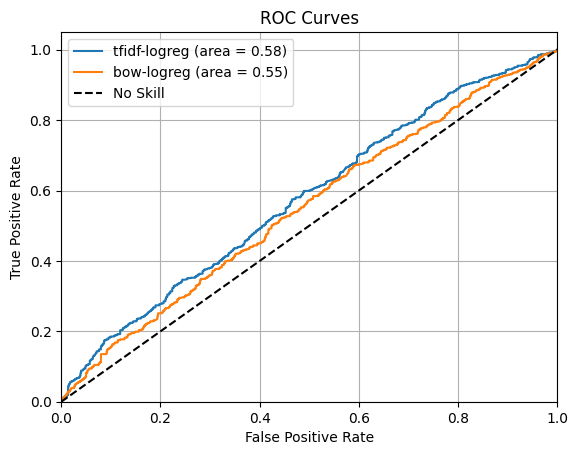

In [60]:
plt.figure()

for model in curves:
    curve = curves[model]
    plt.plot(curve['fpr'], curve['tpr'], label=f"{model} (area = {curve['roc_auc']:0.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('ROC Curves')
plt.legend()
plt.show()